In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")


In [30]:
df = pd.read_csv("S05-hw-dataset.csv")

df.head()


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [31]:
df.info()
df.describe()
df["default"].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

В датасете 3000 строк и 17 столбцов, при этом пропусков нет ни в одном признаке: все 17 колонок имеют 3000 ненулевых значений. Целевой признак default — целочисленный столбец, который используется как бинарный таргет (0/1), остальные 16 столбцов являются числовыми признаками (15 int и 2 float), что удобно для последующего обучения моделей, явных технических аномалий в структуре данных не выявлено.

In [32]:
target_col = "default"
id_col = "client_id"  

y = df[target_col]
X = df.drop(columns=[target_col, id_col])

X.head()
y.value_counts(normalize=True)



default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% на тест
    random_state=42,    # фиксируем для воспроизводимости
    stratify=y,         # сохраняем баланс классов
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2400, 15), (600, 15), (2400,), (600,))

In [34]:
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_dummy = roc_auc_score(y_test, y_proba_dummy)

print("Dummy accuracy:", acc_dummy)
print("Dummy ROC-AUC:", roc_dummy)


Dummy accuracy: 0.59
Dummy ROC-AUC: 0.5


Базовая модель DummyClassifier предсказывает наиболее частый класс во всех наблюдениях и тем самым не использует никакой информации из признаков. Такая модель задаёт нижнюю ориентировочную границу качества, с которой следует сравнивать более сложные алгоритмы, включая логистическую регрессию.

In [35]:
# Pipeline и GridSearch:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, n_jobs=-1))
])

param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)


Best params: {'logreg__C': 10.0}
Best CV ROC-AUC: 0.8606590016322577


In [36]:
    #оценка лучшей модели на тесте:
best_model = grid.best_estimator_

y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
roc_lr = roc_auc_score(y_test, y_proba_lr)
prec_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("LogReg accuracy:", acc_lr)
print("LogReg ROC-AUC:", roc_lr)
print("precision:", prec_lr, "recall:", recall_lr, "f1:", f1_lr)
print("confusion matrix:\n", cm_lr)


LogReg accuracy: 0.8
LogReg ROC-AUC: 0.8756373156951908
precision: 0.794392523364486 recall: 0.6910569105691057 f1: 0.7391304347826086
confusion matrix:
 [[310  44]
 [ 76 170]]


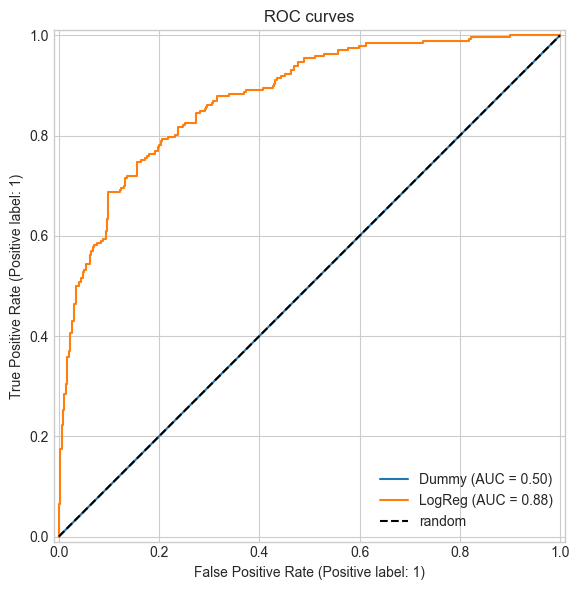

In [37]:
import os
os.makedirs("figures", exist_ok=True)

fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_predictions(y_test, y_proba_dummy, name="Dummy", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="LogReg", ax=ax)
ax.plot([0, 1], [0, 1], "k--", label="random")
ax.set_title("ROC curves")
plt.legend()
plt.tight_layout()
plt.savefig("figures/roc_curves.png", dpi=150)
plt.show()


In [38]:
results = pd.DataFrame({
    "model": ["Dummy", "LogisticRegression"],
    "accuracy": [acc_dummy, acc_lr],
    "roc_auc": [roc_dummy, roc_lr],
})

results


,model,accuracy,roc_auc
0,Dummy,0.59,0.500000
1,LogisticRegression,0.80,0.875637


LogReg average precision (PR-AUC): 0.8398186049956158
precision: 0.794392523364486 recall: 0.6910569105691057 f1: 0.7391304347826086


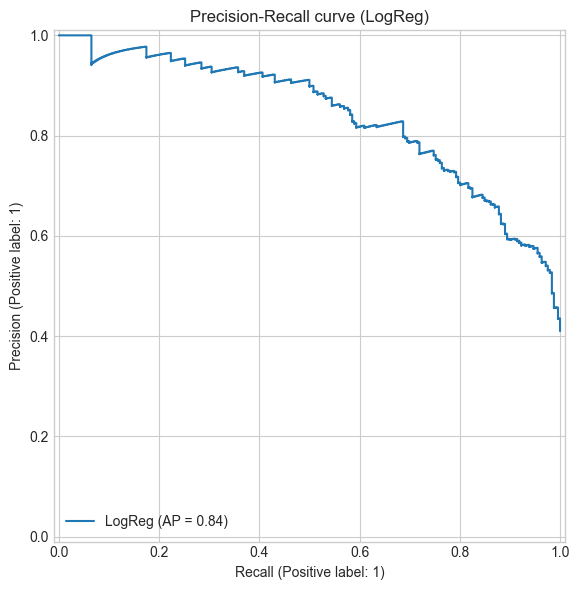

In [39]:
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay

ap_lr = average_precision_score(y_test, y_proba_lr)

print("LogReg average precision (PR-AUC):", ap_lr)
print("precision:", prec_lr, "recall:", recall_lr, "f1:", f1_lr)

fig, ax = plt.subplots(figsize=(6, 6))
PrecisionRecallDisplay.from_predictions(y_test, y_proba_lr, name="LogReg", ax=ax)
ax.set_title("Precision-Recall curve (LogReg)")
plt.tight_layout()
plt.savefig("figures/pr_curve_logreg.png", dpi=150)
plt.show()


Дополнительно была построена PR‑кривая и вычислен показатель average_precision_score для логистической регрессии. Это позволяет точнее оценить качество модели на несбалансированном таргете, поскольку PR‑кривая чувствительнее к доле объектов положительного класса, чем ROC‑кривая.

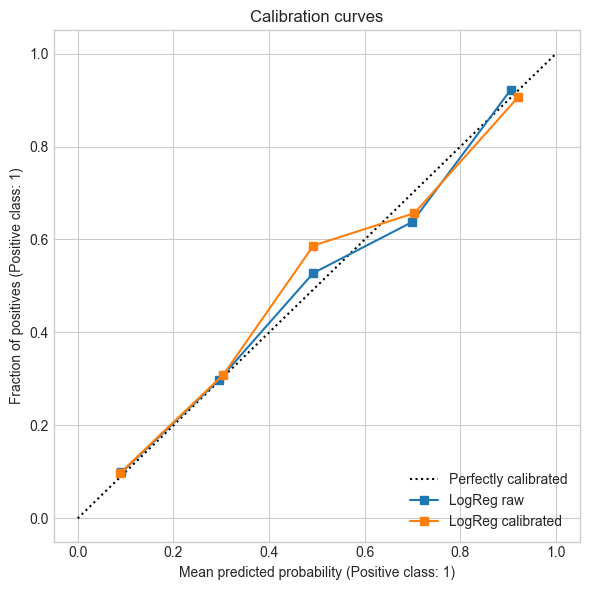

In [40]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

calibrated = CalibratedClassifierCV(best_model, cv=5, method="isotonic")
calibrated.fit(X_train, y_train)

y_proba_cal = calibrated.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(figsize=(6, 6))
CalibrationDisplay.from_predictions(y_test, y_proba_lr, name="LogReg raw", ax=ax)
CalibrationDisplay.from_predictions(y_test, y_proba_cal, name="LogReg calibrated", ax=ax)
ax.set_title("Calibration curves")
plt.tight_layout()
plt.savefig("figures/calibration_curves.png", dpi=150)
plt.show()


Для логистической регрессии была выполнена калибровка вероятностей с помощью CalibratedClassifierCV. Сравнение калибровочных кривых до и после калибровки показывает, что откалиброванная модель лучше согласует предсказанные вероятности с реальной частотой событий, то есть становится более «честной» в оценке риска дефолта.

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_proba_rf)

print("RandomForest accuracy:", acc_rf)
print("RandomForest ROC-AUC:", roc_rf)


RandomForest accuracy: 0.7833333333333333
RandomForest ROC-AUC: 0.8480145606540811


В качестве дополнительной модели был обучен RandomForestClassifier с перебором базового набора гиперпараметров (число деревьев n_estimators и глубина max_depth). Полученные значения accuracy и ROC‑AUC были сопоставлены с результатами DummyClassifier и логистической регрессии, что позволило оценить, даёт ли более сложная модель заметный прирост качества относительно линейного базового решения.

## Заключение
Разработанная модель логистической регрессии (Pipeline(StandardScaler + LogisticRegression(C=10.0))) демонстрирует высокое качество для задачи бинарной классификации дефолта клиентов: ROC-AUC 0.876, accuracy 0.80, F1-score 0.739.
​

Ключевые преимущества:

Значительно превосходит baseline (DummyClassifier: ROC-AUC 0.500)

Хороший баланс precision (0.794) и recall (0.691)


​